In [2]:
from sklearn.cluster import KMeans
from keras.datasets import mnist
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical



In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


C:\Users\MR.Mohebbian\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


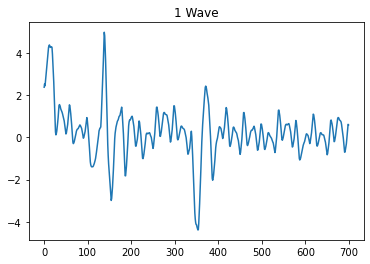

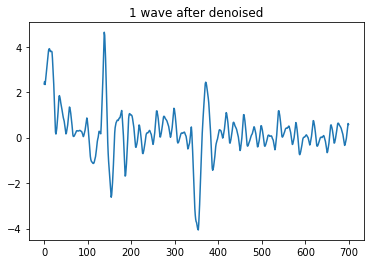

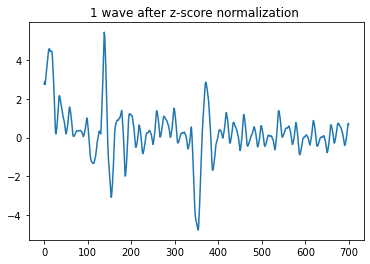

In [4]:
import scipy.io as sio
from scipy import signal
path = "E:\Workspaces\DopplerFHR\Data\\ninfea-non-invasive-multimodal-foetal-ecg-doppler-dataset-for-antenatal-cardiology-research-1.0.0\\dataSave.mat"
window_size = 180
maximum_counting = 10000

AllSignals = list()
mat_contents = sio.loadmat(path)
for i in range(24):
    AllSignals.append(mat_contents['dataSave'][0,i])
AllSignals=np.array(AllSignals)
# Records
finalBeats=[]
for r in range(24):
    signals=AllSignals[r][:,0]
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(str(r) + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(str(r) + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(str(r) + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    beates=[]
    for beatNumber in range(1000):
        beates.append(signals[beatNumber*250:beatNumber*250+250])
    beates=np.array(beates)
 
    signals = signal.resample(beates, 360,axis=1)
    finalBeats.append(signals)
finalBeats=np.asarray(finalBeats)

In [5]:
path = "./Data/mitbih_database/"
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

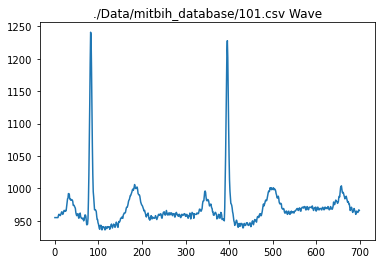

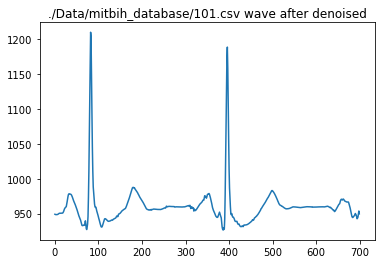

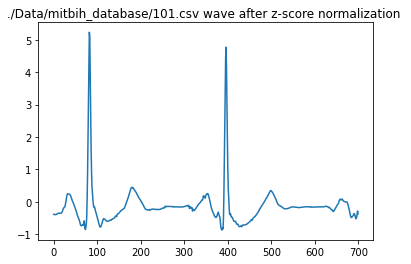

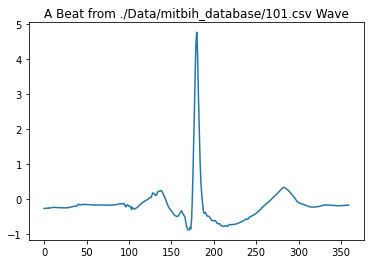

In [6]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

(360,)

In [7]:
X_train_df = pd.DataFrame(np.append(X, np.expand_dims(y,axis=1),axis=1))
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [8]:
train, test = train_test_split(X_train_df, test_size=0.20)
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
# train_y=to_categorical(target_train)
# test_y=to_categorical(target_test)
train_y=target_train
test_y=target_test
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)

(None, 45)
(None, 90, 1)


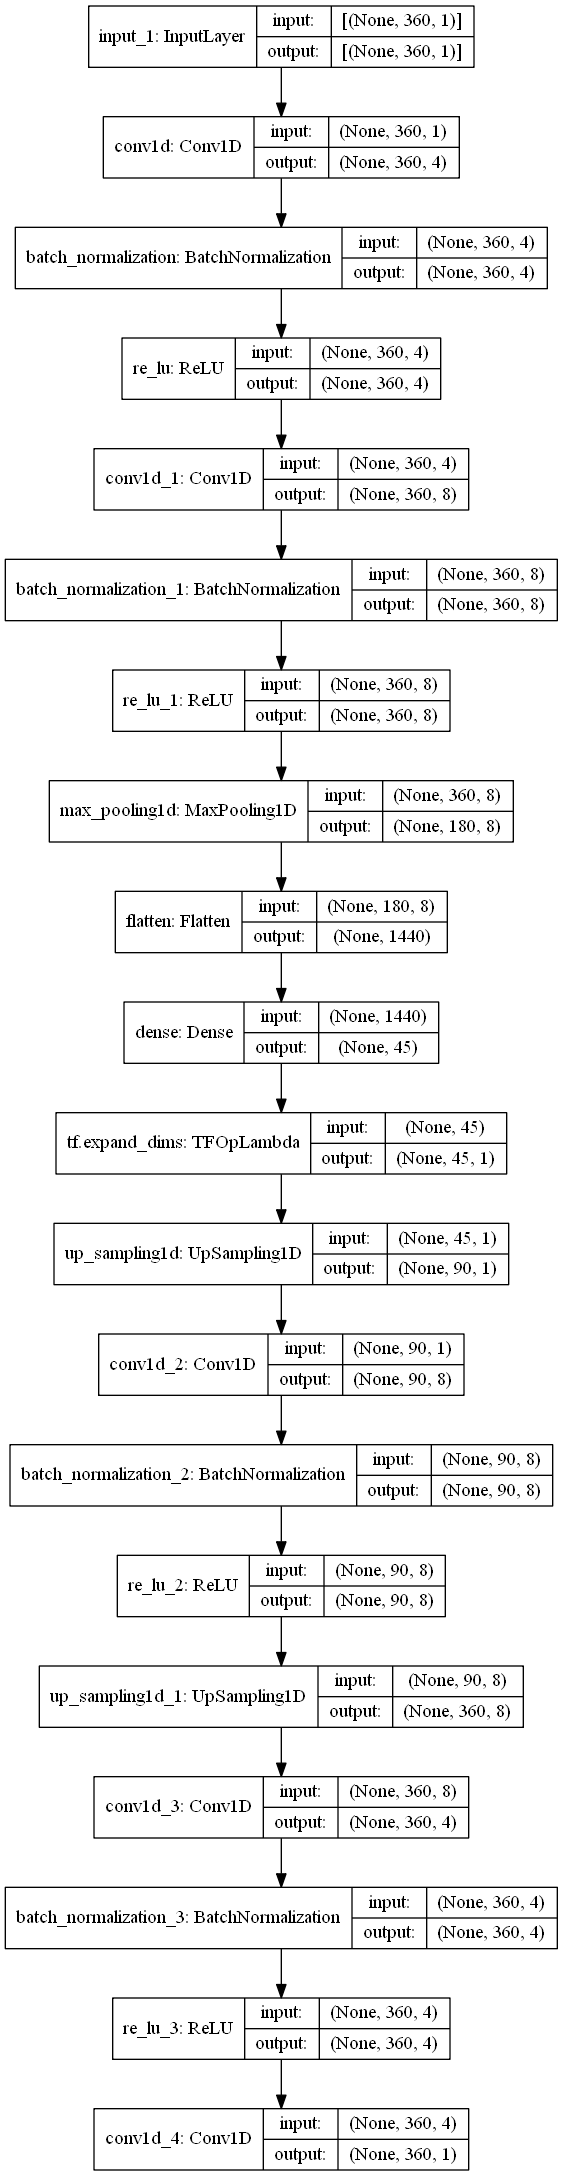

In [9]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=4, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    maxpool=keras.layers.MaxPooling1D(pool_size=2)(conv2)
    flat=keras.layers.Flatten()(maxpool)
    
    embed = keras.layers.Dense(45, activation='relu')(flat)
    print(embed.shape)
    embed=keras.backend.expand_dims(embed,2)
    upsampled=keras.layers.UpSampling1D(size=2)(embed)
    print(upsampled.shape)
    conv3 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(upsampled)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    upsampled=keras.layers.UpSampling1D(size=4)(conv3)
    conv4 = keras.layers.Conv1D(filters=4, kernel_size=3, padding="same")(upsampled)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)
    
    output_layer = keras.layers.Conv1D(filters=1, kernel_size=3, padding="same")(conv4)
    # output_layer = keras.layers.Dense(1, activation='relu')(conv4)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=test_x.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [10]:
# x_final=np.append(train_x,finalBeats,axis=1)
finalBeatsReshaped=finalBeats.reshape((-1,360,1))
x_final=np.append(train_x,finalBeatsReshaped,axis=0)

In [11]:
epochs = 5
batch_size = 16

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="nadam",
    loss="mae",
    metrics=["mae"],
)


history = model.fit(
    train_x,
    train_x,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
1000/1000 [==============================] - 10s 8ms/step - loss: 0.4980 - mae: 0.4980 - val_loss: 0.3375 - val_mae: 0.3375
Epoch 2/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3537 - mae: 0.3537 - val_loss: 0.2986 - val_mae: 0.2986
Epoch 3/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3163 - mae: 0.3163 - val_loss: 0.3059 - val_mae: 0.3059
Epoch 4/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3031 - mae: 0.3031 - val_loss: 0.2620 - val_mae: 0.2620
Epoch 5/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2885 - mae: 0.2885 - val_loss: 0.2704 - val_mae: 0.2704


In [12]:
from keras.models import Model

embeddingModel = Model(inputs=model.input,
                                 outputs=model.get_layer('dense').output)

# y_output_test=model.predict(test_x)
y_embedding_test=embeddingModel.predict(train_x)

In [13]:
targetFinal=np.append(np.expand_dims(train_y,1),np.ones((24000,1))*5,axis=0)

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
cmap = plt.cm.get_cmap('jet')
classNames=['N', 'L', 'R', 'A', 'V','FECG']
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
dataPlotX=[]
dataPlotY=[]
def plot_in_group(tx,ty,targetTrain):
    fig = plt.figure()
    # ax = fig.add_subplot(111,projection='3d')
    ax = fig.add_subplot(111)
    for i in range(6):
        txG=tx[targetTrain==i]
        tyG=ty[targetTrain==i]
        # tzG=tz[targetTrain==i]
        targetTrainG=targetTrain[targetTrain==i]
        ax.scatter(txG[1:1000], tyG[1:1000], c=cmap(i/6),label=classNames[i])
        dataPlotX.extend(txG[1:1000])
        dataPlotY.extend(tyG[1:1000])
    plt.tight_layout()
    plt.legend()
    fig.savefig('tsne_trained.png', dpi=100)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

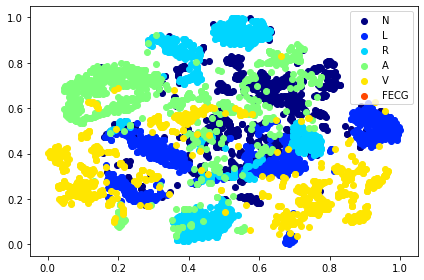

In [16]:
tsne = TSNE(n_components=2,perplexity=60).fit_transform(y_embedding_test[:,:])
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
plot_in_group(tx,ty,train_y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

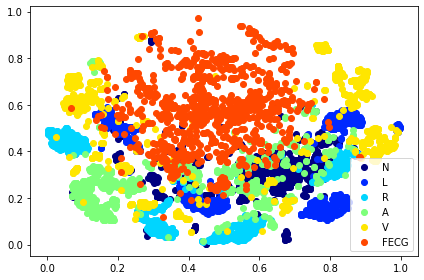

In [37]:
from keras.models import Model

embeddingModel = Model(inputs=model.input,
                                 outputs=model.get_layer('dense').output)

# y_output_test=model.predict(test_x)
y_embedding_final=embeddingModel.predict(x_final)

tsne = TSNE(n_components=2,perplexity=40).fit_transform(y_embedding_final)

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
plot_in_group(tx,ty,targetFinal[:,0])

In [45]:
len(np.unique(clustering.labels_))

468

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

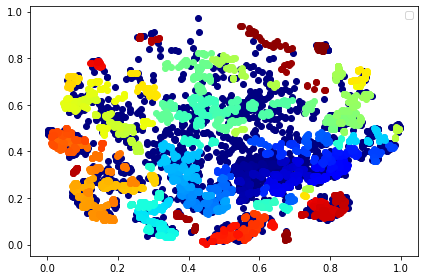

In [43]:
from sklearn.cluster import OPTICS
tsneNormalized=np.asarray([dataPlotX,dataPlotY]).T
clustering = OPTICS(min_samples=5).fit(tsneNormalized)
def plot_in_group(tx,ty,targetTrain):
    fig = plt.figure()
    # ax = fig.add_subplot(111,projection='3d')
    ax = fig.add_subplot(111)
    classNum=len(np.unique(targetTrain))
    for i in range(-1,classNum-1):
        txG=tx[targetTrain==i]
        tyG=ty[targetTrain==i]
        # tzG=tz[targetTrain==i]
        targetTrainG=targetTrain[targetTrain==i]
        ax.scatter(txG, tyG, c=cmap(i/classNum))
    plt.tight_layout()
    plt.legend()
    fig.savefig('tsne_trained.png', dpi=100)
plot_in_group(np.asarray(dataPlotX),np.asarray(dataPlotY),clustering.labels_)

In [44]:
import gc
gc.collect()

65593

In [29]:
np.asarray(dataPlotY).shape

(5994,)